# Session 1: Foundations of Volatility - Stylized Facts and Statistical Properties

## Course: Advanced Volatility Modeling

---

## Learning Objectives

By the end of this session, students will be able to:
1. Define volatility mathematically and understand its role in financial markets
2. Identify and empirically verify the stylized facts of financial returns
3. Understand why simple models (e.g., geometric Brownian motion) fail to capture market dynamics
4. Motivate the need for sophisticated volatility models

---

## 1. Introduction to Volatility

### 1.1 What is Volatility?

Volatility measures the dispersion of returns for a given security or market index. In mathematical finance, we distinguish between several concepts:

**Historical (Realized) Volatility**: The standard deviation of logarithmic returns over a historical period:

$$\sigma_{\text{hist}} = \sqrt{\frac{1}{T-1} \sum_{t=1}^{T} (r_t - \bar{r})^2}$$

where $r_t = \ln(P_t/P_{t-1})$ are log-returns and $\bar{r}$ is the sample mean.

**Implied Volatility**: The volatility parameter extracted from option prices using the Black-Scholes formula (or other pricing models).

**Conditional Volatility**: The expected volatility at time $t$ given information available at time $t-1$:

$$\sigma_t^2 = \text{Var}(r_t | \mathcal{F}_{t-1})$$

where $\mathcal{F}_{t-1}$ is the information set (sigma-algebra) at time $t-1$.

### 1.2 Why Does Volatility Matter?

- **Risk Management**: VaR, Expected Shortfall, portfolio optimization
- **Derivative Pricing**: Options are essentially volatility instruments
- **Asset Allocation**: Risk parity, mean-variance optimization
- **Regulatory Capital**: Basel requirements for banks

## 2. Mathematical Foundations

### 2.1 The Geometric Brownian Motion Benchmark

The starting point for financial modeling is often Geometric Brownian Motion (GBM):

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

where $W_t$ is a standard Brownian motion. By Itô's lemma, log-prices follow:

$$d\ln S_t = \left(\mu - \frac{\sigma^2}{2}\right) dt + \sigma dW_t$$

This implies that log-returns over interval $\Delta t$ are:

$$r_t = \ln\left(\frac{S_t}{S_{t-\Delta t}}\right) \sim \mathcal{N}\left(\left(\mu - \frac{\sigma^2}{2}\right)\Delta t, \sigma^2 \Delta t\right)$$

**Key Implications of GBM:**
1. Returns are i.i.d. (independent and identically distributed)
2. Returns are normally distributed
3. Volatility $\sigma$ is constant over time

We will show that **all three assumptions are violated in real data**.

### 2.2 Annualization of Volatility

If daily volatility is $\sigma_d$, then annual volatility is:

$$\sigma_{\text{annual}} = \sigma_d \sqrt{252}$$

assuming 252 trading days per year. This follows from the scaling property of variance:

$$\text{Var}(r_{[0,T]}) = T \cdot \text{Var}(r_{[0,1]})$$

under the assumption of independent returns.

## 3. Empirical Analysis: Setting Up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm, jarque_bera, kurtosis, skew
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [2]:
# Download data for multiple assets
tickers = {
    'SPY': 'S&P 500 ETF',
    'BTC-USD': 'Bitcoin',
    'EURUSD=X': 'EUR/USD',
    'GC=F': 'Gold Futures'
}

start_date = '2015-01-01'
end_date = '2024-12-31'

data = {}
for ticker, name in tickers.items():
    df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if len(df) > 0:
        # Handle multi-index columns from yfinance
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = df.columns.get_level_values(0)
        data[name] = df['Close'].dropna()

print(f"Data downloaded for: {list(data.keys())}")
for name, series in data.items():
    print(f"{name}: {len(series)} observations from {series.index[0].date()} to {series.index[-1].date()}")

YF.download() has changed argument auto_adjust default to True
Data downloaded for: ['S&P 500 ETF', 'Bitcoin', 'EUR/USD', 'Gold Futures']
S&P 500 ETF: 2515 observations from 2015-01-02 to 2024-12-30
Bitcoin: 3652 observations from 2015-01-01 to 2024-12-30
EUR/USD: 2605 observations from 2015-01-01 to 2024-12-30
Gold Futures: 2512 observations from 2015-01-02 to 2024-12-30


In [3]:
def compute_returns(prices, method='log'):
    """Compute returns from price series.
    
    Parameters
    ----------
    prices : pd.Series
        Price series
    method : str
        'log' for logarithmic returns, 'simple' for arithmetic returns
    
    Returns
    -------
    pd.Series
        Returns series
    """
    if method == 'log':
        return np.log(prices / prices.shift(1)).dropna()
    else:
        return prices.pct_change().dropna()

# Compute log returns for all assets
returns = {name: compute_returns(prices) for name, prices in data.items()}

## 4. Stylized Facts of Financial Returns

Financial returns exhibit several robust empirical regularities, often called **stylized facts**. These patterns are observed across different markets, assets, and time periods.

### 4.1 Stylized Fact 1: Heavy Tails (Leptokurtosis)

Financial returns have heavier tails than the normal distribution. This means extreme events occur more frequently than a Gaussian model would predict.

**Kurtosis** measures the heaviness of tails:

$$\kappa = \frac{E[(X - \mu)^4]}{\sigma^4}$$

For the normal distribution, $\kappa = 3$. **Excess kurtosis** is $\kappa - 3$, which is positive for heavy-tailed distributions.

In [5]:
def descriptive_statistics(returns_dict):
    """Compute descriptive statistics for return series."""
    stats_list = []
    for name, ret in returns_dict.items():
        stats_dict = {
            'Asset': name,
            'N': len(ret),
            'Mean (%)': ret.mean() * 100,
            'Std Dev (%)': ret.std() * 100,
            'Annual Vol (%)': ret.std() * np.sqrt(252) * 100,
            'Skewness': skew(ret),
            'Excess Kurtosis': kurtosis(ret),  # scipy computes excess kurtosis
            'Min (%)': ret.min() * 100,
            'Max (%)': ret.max() * 100,
            'JB Statistic': jarque_bera(ret)[0],
            'JB p-value': jarque_bera(ret)[1]
        }
        stats_list.append(stats_dict)
    
    return pd.DataFrame(stats_list).set_index('Asset').round(4)

stats_df = descriptive_statistics(returns)
print("Descriptive Statistics of Daily Returns")
print("="*60)
stats_df

Descriptive Statistics of Daily Returns


,N,Mean (%),Std Dev (%),Annual Vol (%),Skewness,Excess Kurtosis,Min (%),Max (%),JB Statistic,JB p-value
Asset,,,,,,,,,,
S&P 500 ETF,2514,0.0488,1.1139,17.6824,-0.8006,13.6301,-11.5887,8.6731,19728.9687,0.0
Bitcoin,3651,0.1557,3.6544,58.0126,-0.7522,11.5638,-46.4730,22.5119,20686.6804,0.0
EUR/USD,2604,-0.0057,0.4974,7.8961,-0.0516,2.6055,-2.8144,2.8145,737.7418,0.0
Gold Futures,2511,0.0314,0.9252,14.6878,-0.1489,3.6951,-5.1069,5.7775,1437.7671,0.0


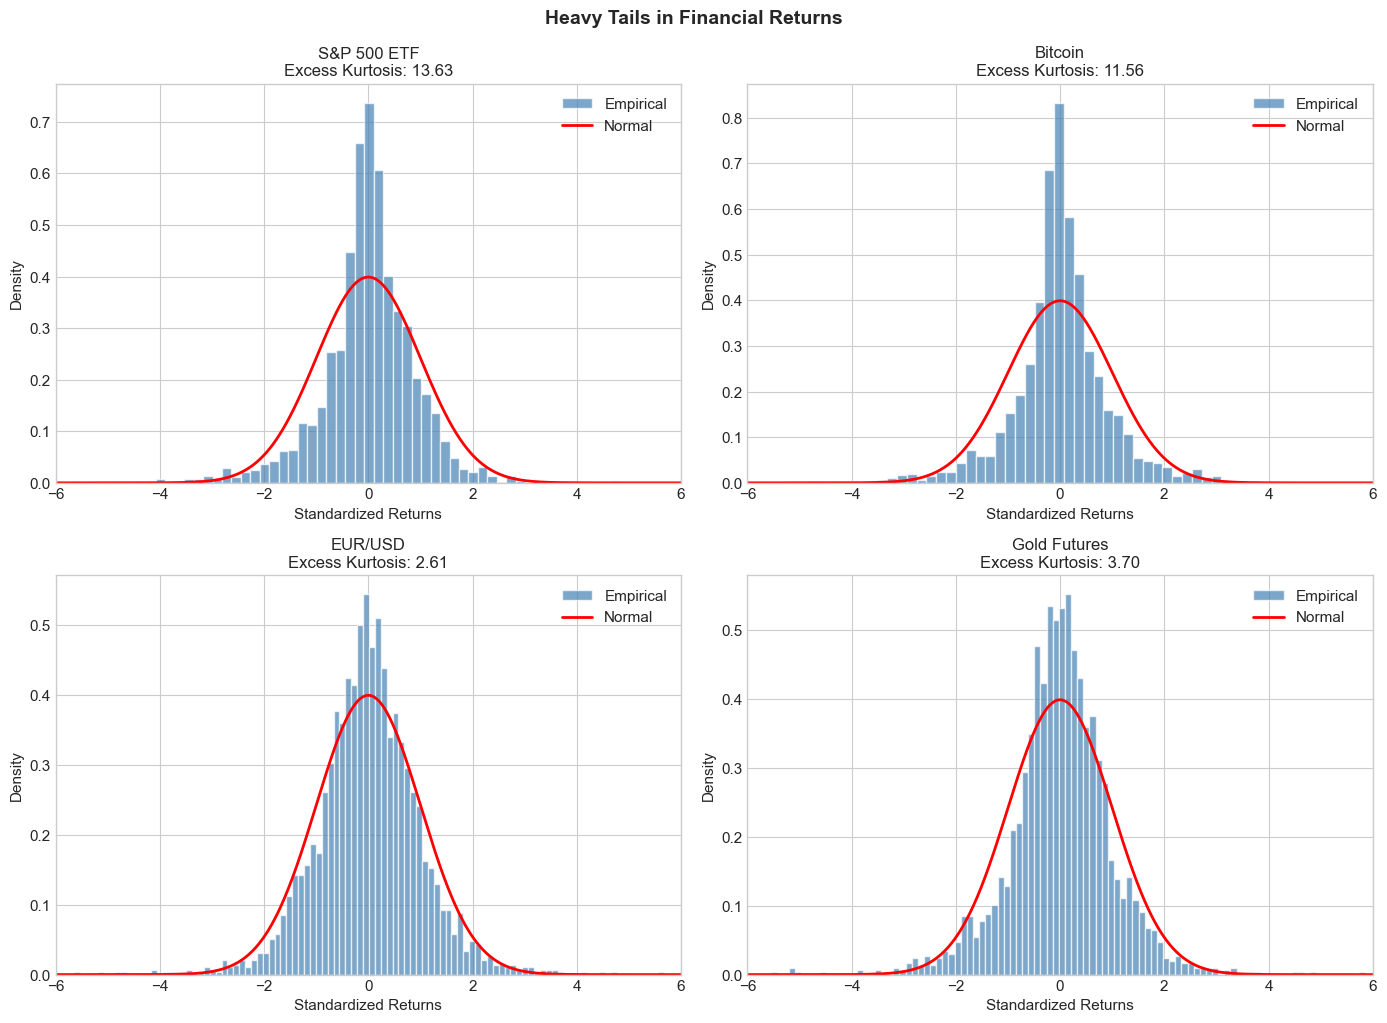

In [6]:
# Visual comparison with normal distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, ret) in zip(axes, returns.items()):
    # Standardize returns
    ret_standardized = (ret - ret.mean()) / ret.std()
    
    # Histogram
    ax.hist(ret_standardized, bins=100, density=True, alpha=0.7, 
            label='Empirical', color='steelblue', edgecolor='white')
    
    # Normal distribution overlay
    x = np.linspace(-6, 6, 1000)
    ax.plot(x, norm.pdf(x), 'r-', lw=2, label='Normal')
    
    ax.set_title(f'{name}\nExcess Kurtosis: {kurtosis(ret):.2f}', fontsize=12)
    ax.set_xlabel('Standardized Returns')
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_xlim(-6, 6)

plt.tight_layout()
plt.suptitle('Heavy Tails in Financial Returns', y=1.02, fontsize=14, fontweight='bold')
plt.show()

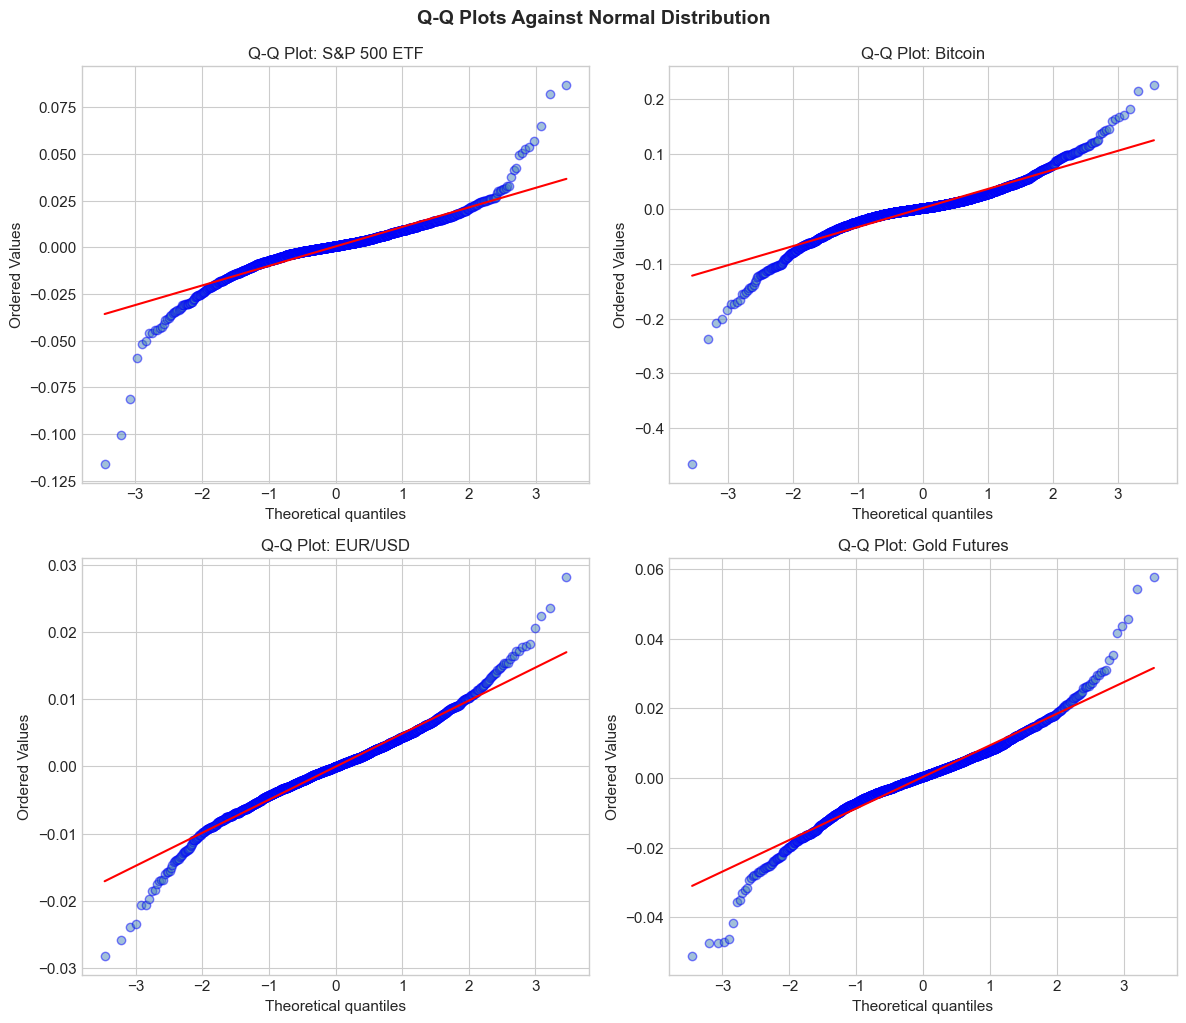


Interpretation: Deviations from the red line, especially in the tails,
indicate departures from normality. S-shaped patterns suggest heavy tails.


In [7]:
# Q-Q plots for normality assessment
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, ret) in zip(axes, returns.items()):
    stats.probplot(ret, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot: {name}', fontsize=12)
    ax.get_lines()[0].set_markerfacecolor('steelblue')
    ax.get_lines()[0].set_alpha(0.5)
    ax.get_lines()[1].set_color('red')

plt.tight_layout()
plt.suptitle('Q-Q Plots Against Normal Distribution', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print("\nInterpretation: Deviations from the red line, especially in the tails,")
print("indicate departures from normality. S-shaped patterns suggest heavy tails.")

### 4.2 Stylized Fact 2: Volatility Clustering

Large returns (in absolute value) tend to be followed by large returns, and small returns tend to be followed by small returns. This creates periods of high and low volatility.

Mathematically, while returns themselves show little autocorrelation:
$$\text{Corr}(r_t, r_{t-k}) \approx 0 \quad \text{for } k \geq 1$$

Squared or absolute returns show significant positive autocorrelation:
$$\text{Corr}(|r_t|, |r_{t-k}|) > 0 \quad \text{and persists for large } k$$

This is the key motivation for **GARCH-type models**.

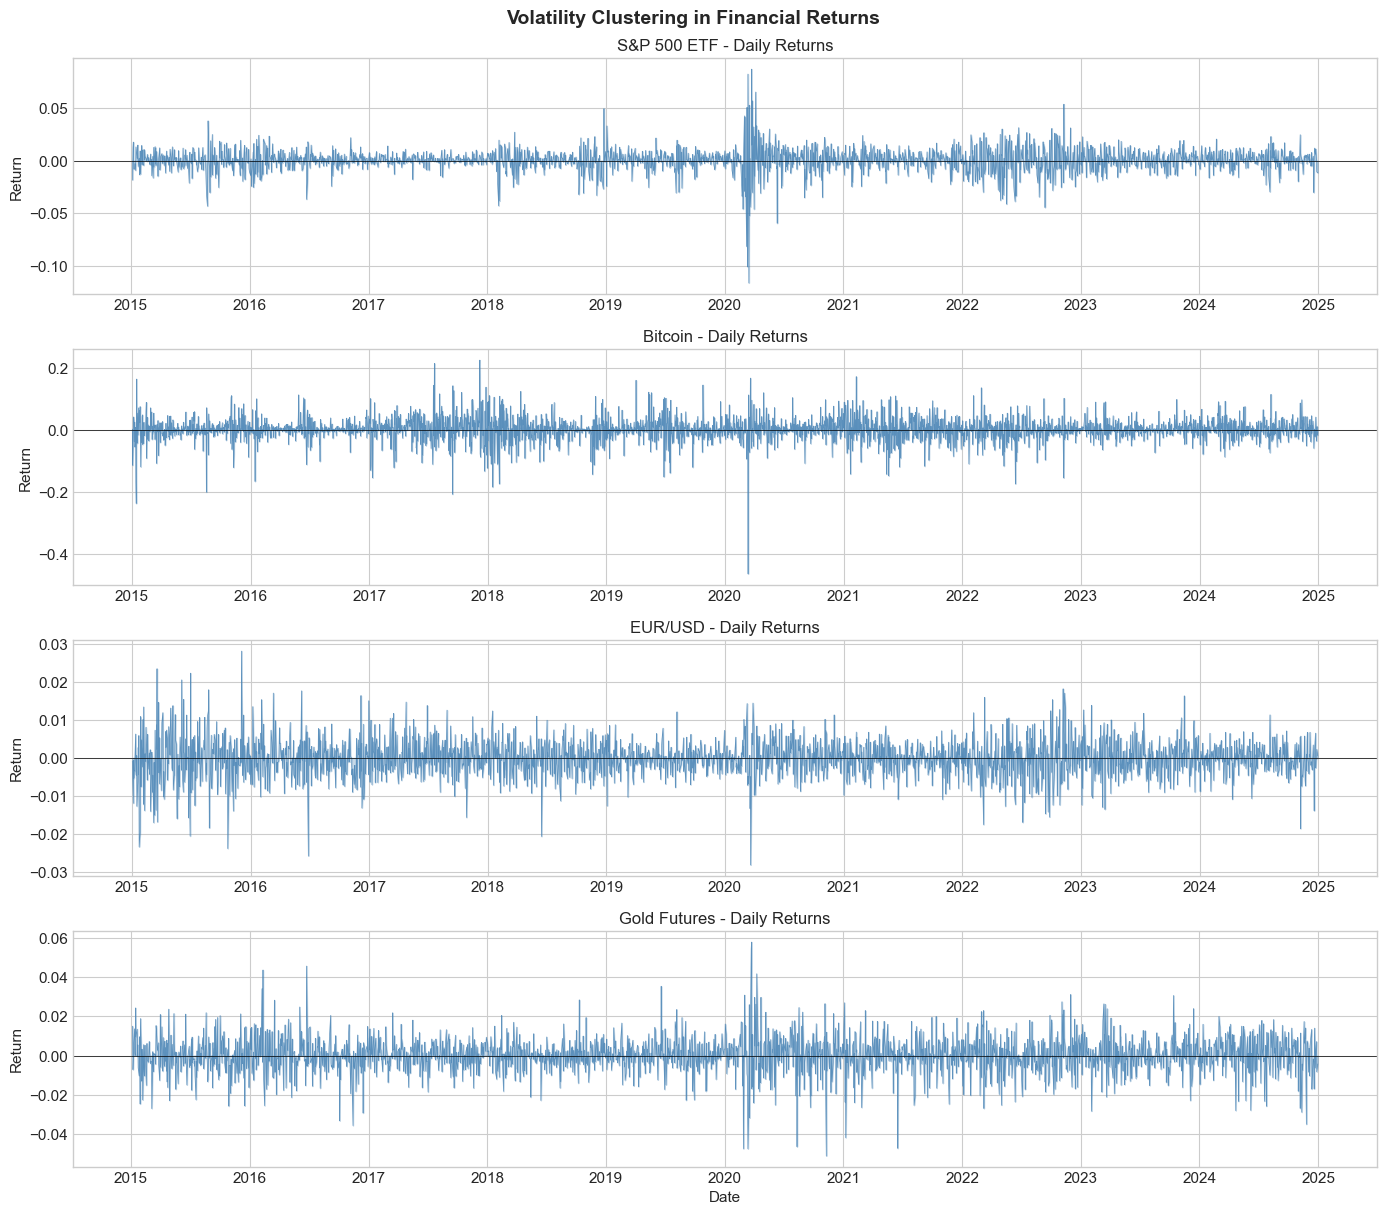

In [9]:
# Visualize volatility clustering
fig, axes = plt.subplots(len(returns), 1, figsize=(14, 3*len(returns)))

for ax, (name, ret) in zip(axes, returns.items()):
    ax.plot(ret.index, ret.values, color='steelblue', alpha=0.8, linewidth=0.5)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.fill_between(ret.index, ret.values, 0, alpha=0.3, color='steelblue')
    ax.set_title(f'{name} - Daily Returns', fontsize=12)
    ax.set_ylabel('Return')

plt.xlabel('Date')
plt.tight_layout()
plt.suptitle('Volatility Clustering in Financial Returns', y=1.01, fontsize=14, fontweight='bold')
plt.show()

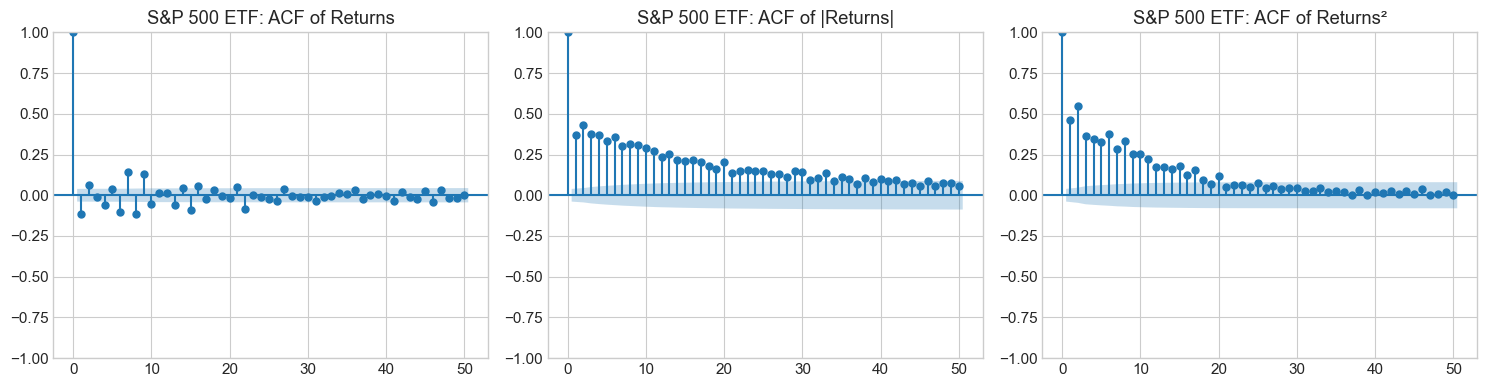

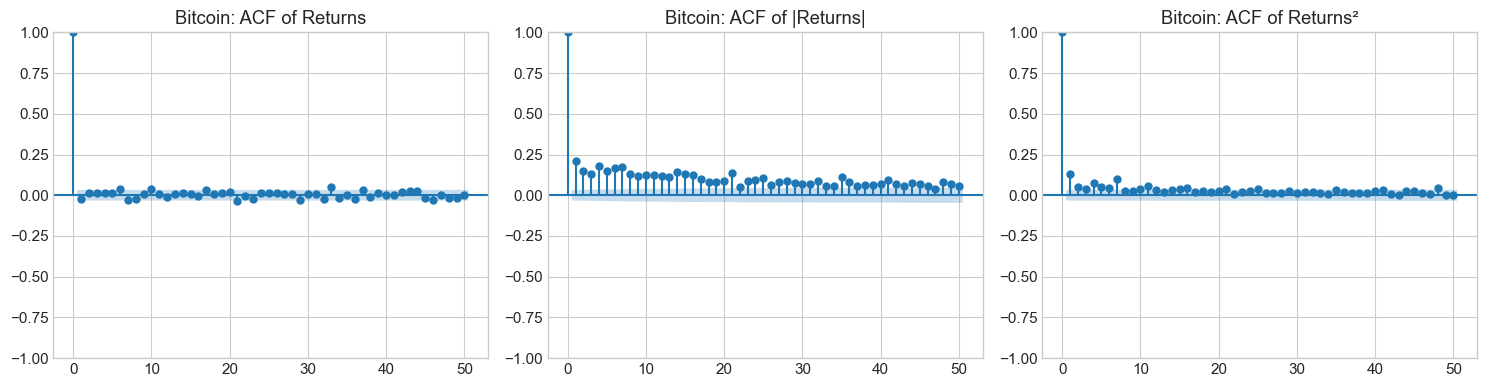

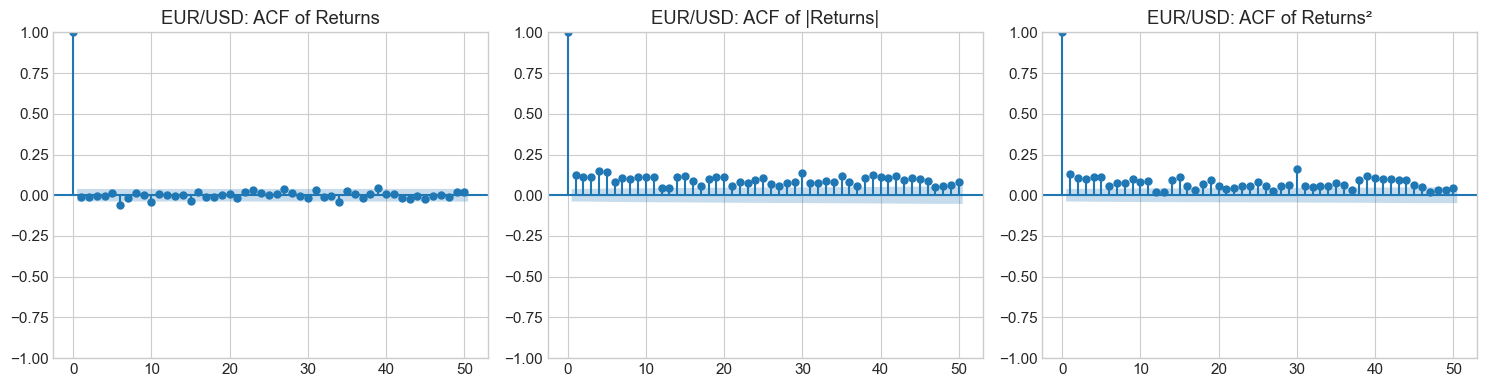

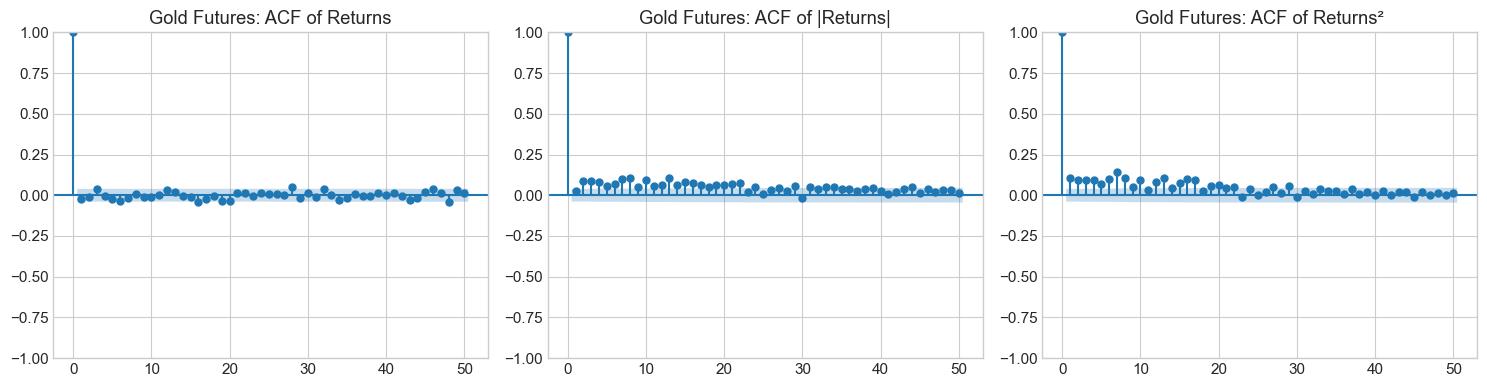

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

def plot_acf_comparison(returns_series, name, max_lags=50):
    """Plot ACF of returns vs squared returns."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # ACF of returns
    plot_acf(returns_series, lags=max_lags, ax=axes[0], alpha=0.05,
             title=f'{name}: ACF of Returns')
    
    # ACF of absolute returns
    plot_acf(np.abs(returns_series), lags=max_lags, ax=axes[1], alpha=0.05,
             title=f'{name}: ACF of |Returns|')
    
    # ACF of squared returns
    plot_acf(returns_series**2, lags=max_lags, ax=axes[2], alpha=0.05,
             title=f'{name}: ACF of Returns²')
    
    plt.tight_layout()
    plt.show()

for name, ret in returns.items():
    plot_acf_comparison(ret, name)

### 4.3 Stylized Fact 3: Leverage Effect (Asymmetry)

Negative returns tend to increase future volatility more than positive returns of the same magnitude. This asymmetry is called the **leverage effect** (Black, 1976).

The name comes from the corporate finance explanation: when stock prices fall, the firm's debt-to-equity ratio increases, making the stock riskier.

Mathematically:
$$\text{Corr}(r_t, \sigma_{t+1}^2) < 0$$

This motivates **asymmetric GARCH models** like EGARCH and GJR-GARCH.

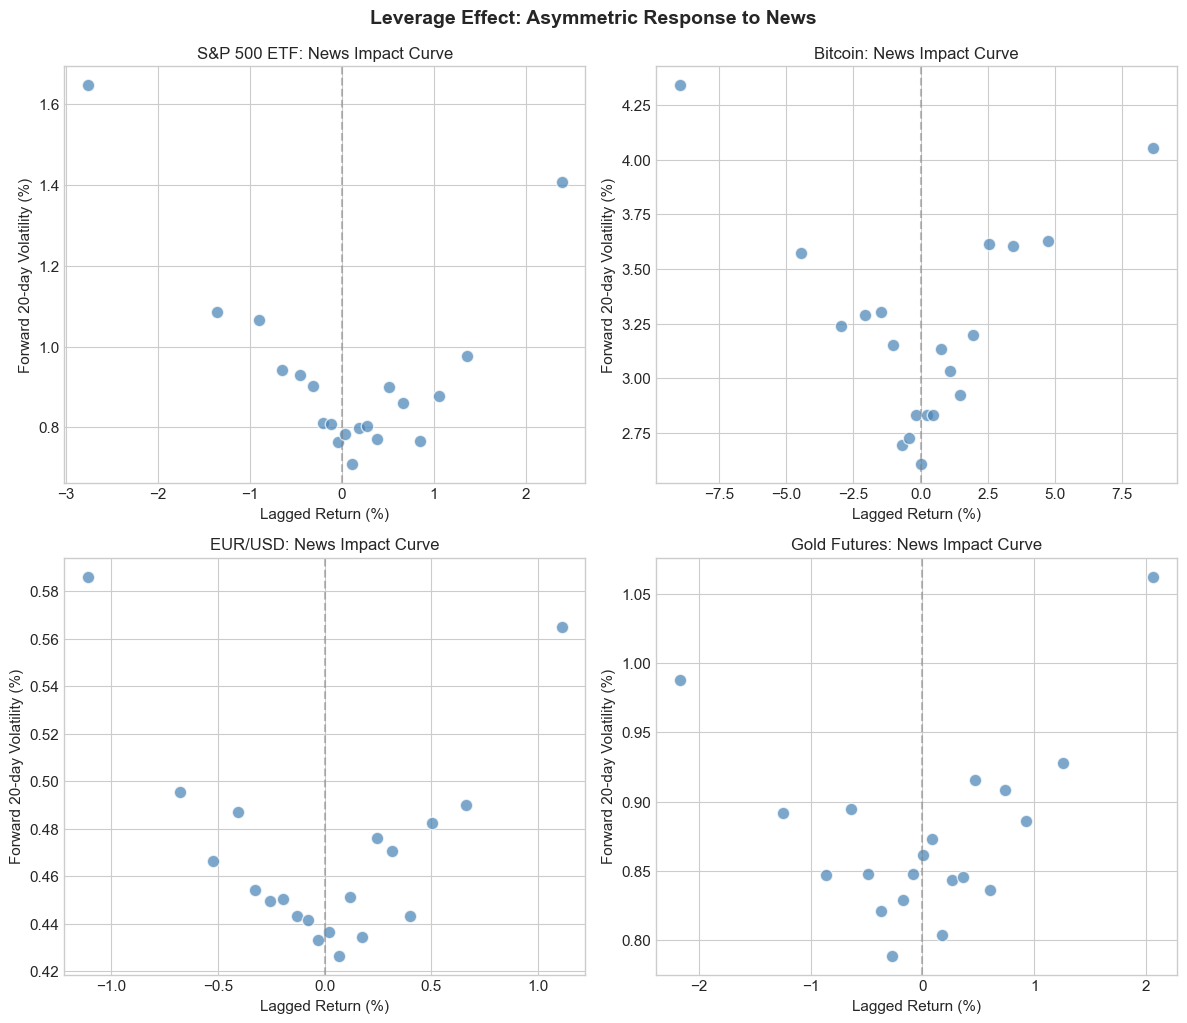


Interpretation: If negative returns (left side) correspond to higher
forward volatility than positive returns, we have evidence of the leverage effect.


In [12]:
def news_impact_analysis(returns_series, name):
    """Analyze asymmetric impact of positive vs negative returns on future volatility."""
    ret = returns_series.copy()
    
    # Create lagged returns and forward realized volatility (20-day)
    df = pd.DataFrame({
        'return': ret,
        'return_lag': ret.shift(1),
        'fwd_vol': ret.rolling(window=20).std().shift(-20)
    }).dropna()
    
    # Bin lagged returns
    df['return_bin'] = pd.qcut(df['return_lag'], q=20, labels=False, duplicates='drop')
    
    # Compute mean forward volatility by bin
    grouped = df.groupby('return_bin').agg({
        'return_lag': 'mean',
        'fwd_vol': 'mean'
    }).sort_values('return_lag')
    
    return grouped

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, ret) in zip(axes, returns.items()):
    grouped = news_impact_analysis(ret, name)
    ax.scatter(grouped['return_lag']*100, grouped['fwd_vol']*100, 
               s=80, c='steelblue', alpha=0.7, edgecolor='white')
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Lagged Return (%)')
    ax.set_ylabel('Forward 20-day Volatility (%)')
    ax.set_title(f'{name}: News Impact Curve', fontsize=12)

plt.tight_layout()
plt.suptitle('Leverage Effect: Asymmetric Response to News', y=1.02, fontsize=14, fontweight='bold')
plt.show()

print("\nInterpretation: If negative returns (left side) correspond to higher")
print("forward volatility than positive returns, we have evidence of the leverage effect.")

### 4.4 Stylized Fact 4: Long Memory in Volatility

The autocorrelation of squared or absolute returns decays slowly - much slower than exponential decay would predict. This suggests **long memory** or **long-range dependence**.

For a long-memory process, the autocorrelation function decays hyperbolically:
$$\rho(k) \sim k^{2d-1} \quad \text{as } k \to \infty$$

where $d \in (0, 0.5)$ is the **fractional differencing parameter**.

This motivates **FIGARCH** and **long-memory volatility models**, and connects to **rough volatility** (which we'll cover later).

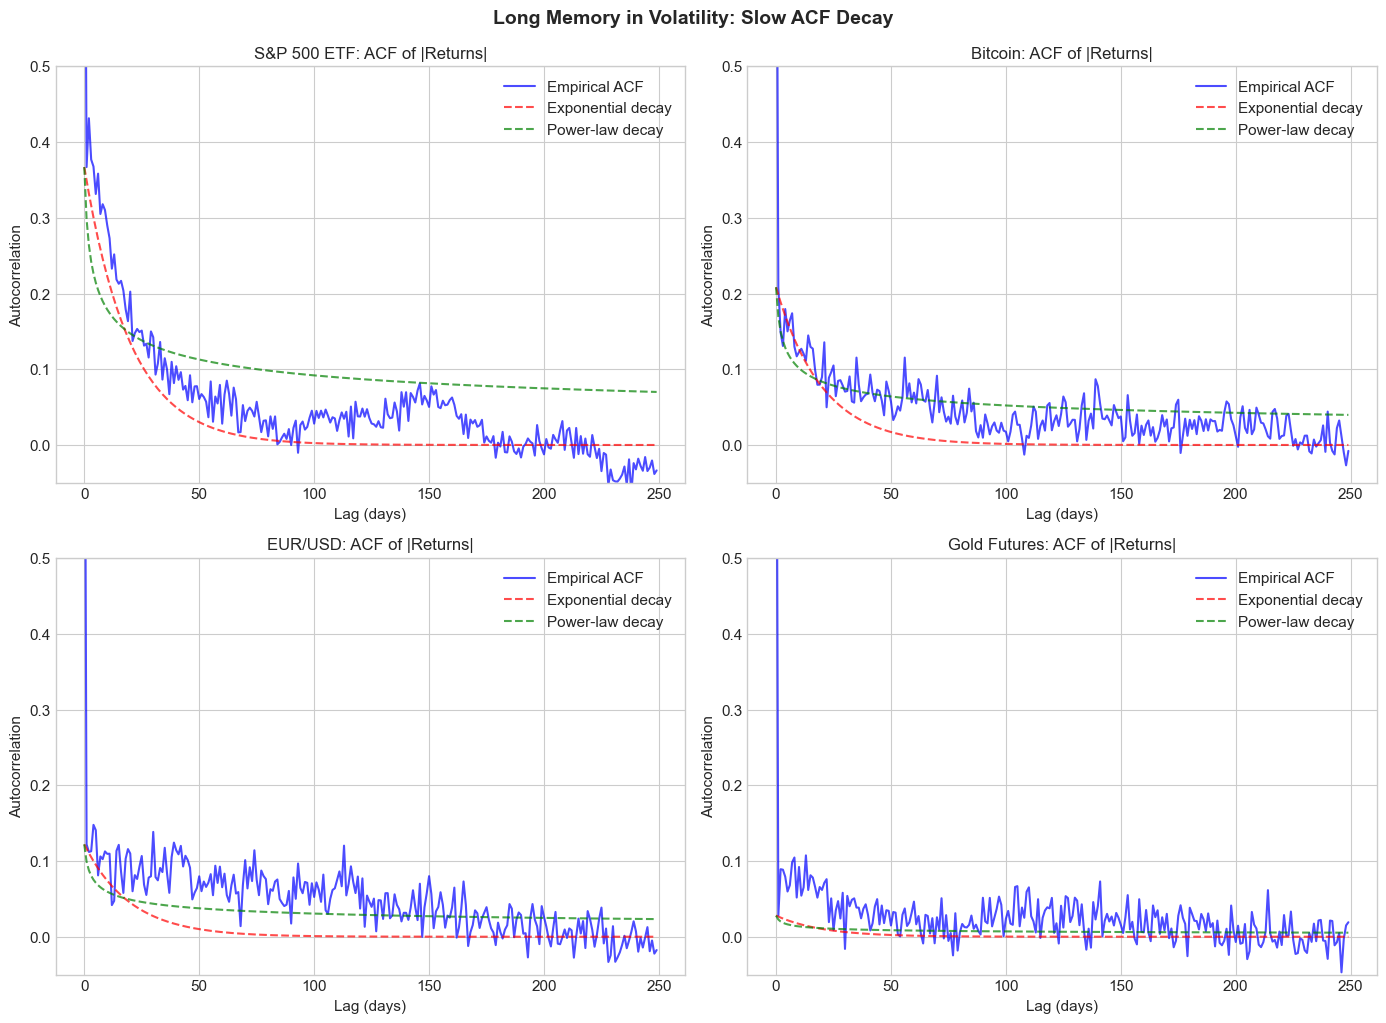

In [14]:
def compute_acf(series, max_lag=500):
    """Compute autocorrelation function."""
    n = len(series)
    mean = series.mean()
    var = series.var()
    acf = np.zeros(max_lag)
    
    for k in range(max_lag):
        acf[k] = np.mean((series.iloc[k:] - mean) * (series.iloc[:-k if k > 0 else n].values - mean)) / var
    
    return acf

# Compare ACF decay patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
max_lag = 250

for ax, (name, ret) in zip(axes, returns.items()):
    abs_ret = np.abs(ret)
    acf_vals = compute_acf(abs_ret, max_lag=max_lag)
    lags = np.arange(max_lag)
    
    # Plot ACF
    ax.plot(lags, acf_vals, 'b-', alpha=0.7, label='Empirical ACF')
    
    # Fit exponential decay (short memory)
    exp_decay = acf_vals[1] * np.exp(-0.05 * lags)
    ax.plot(lags, exp_decay, 'r--', alpha=0.7, label='Exponential decay')
    
    # Fit power-law decay (long memory)
    power_decay = acf_vals[1] * (lags + 1) ** (-0.3)
    ax.plot(lags, power_decay, 'g--', alpha=0.7, label='Power-law decay')
    
    ax.set_xlabel('Lag (days)')
    ax.set_ylabel('Autocorrelation')
    ax.set_title(f'{name}: ACF of |Returns|', fontsize=12)
    ax.legend()
    ax.set_ylim(-0.05, 0.5)

plt.tight_layout()
plt.suptitle('Long Memory in Volatility: Slow ACF Decay', y=1.02, fontsize=14, fontweight='bold')
plt.show()

### 4.5 Stylized Fact 5: Aggregational Gaussianity

While daily returns are non-Gaussian, returns over longer horizons (weekly, monthly) tend to become more Gaussian. This is a manifestation of the Central Limit Theorem, but the convergence is slower than for i.i.d. variables due to dependence in volatility.

$$r_t^{(h)} = \sum_{i=1}^{h} r_{t-h+i} \xrightarrow{d} \mathcal{N} \quad \text{as } h \to \infty$$

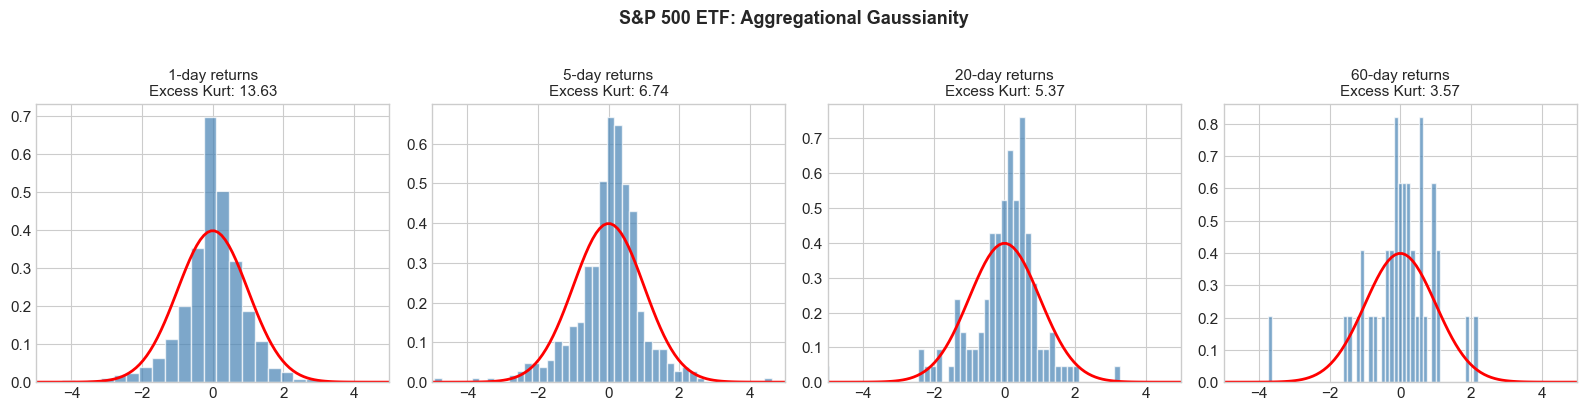

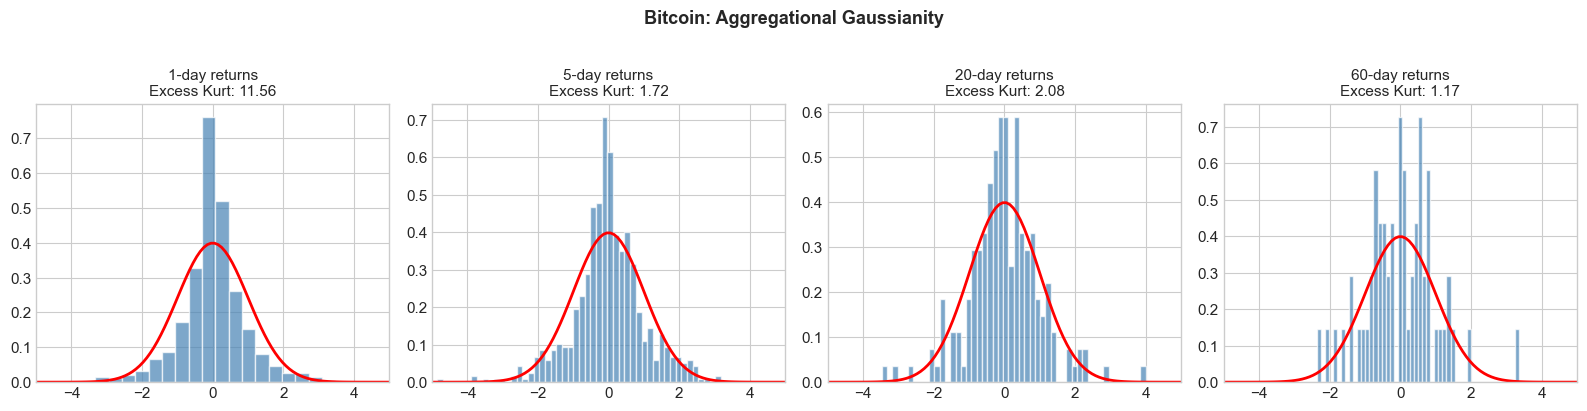

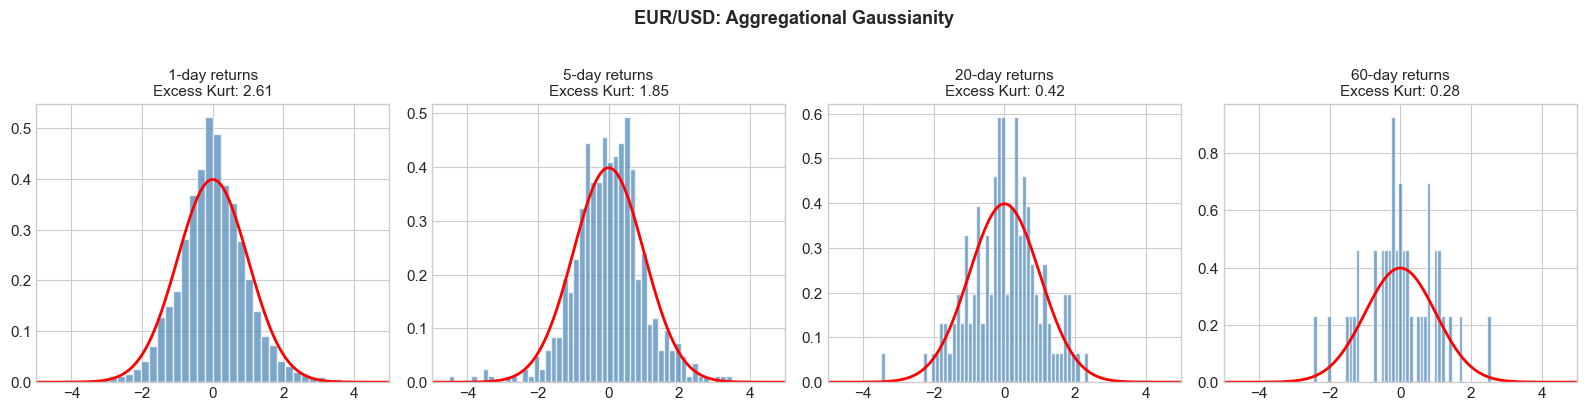

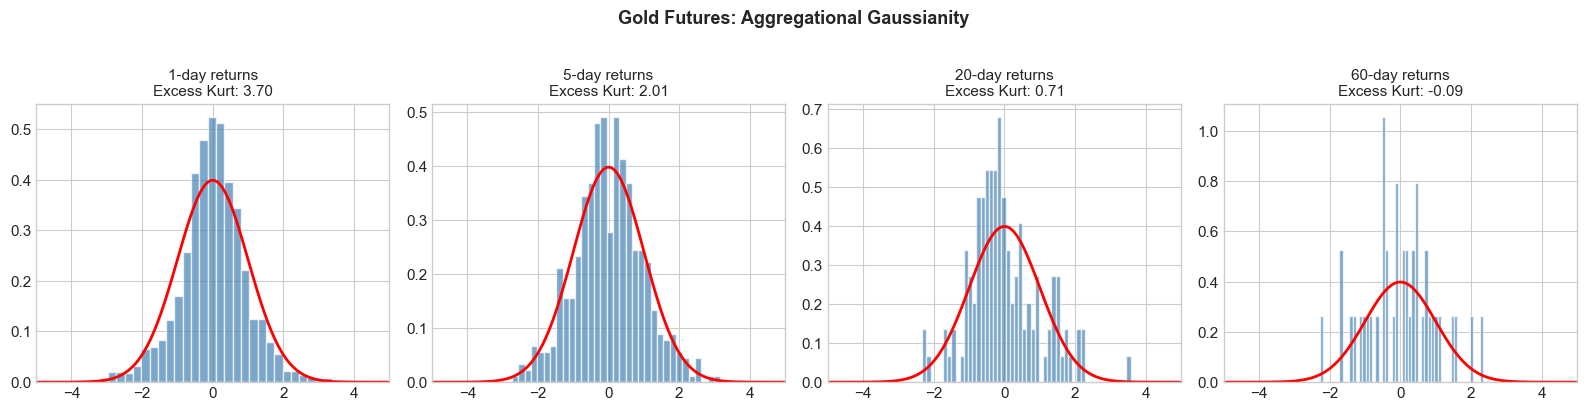

In [16]:
def aggregational_gaussianity(returns_series, name, horizons=[1, 5, 20, 60]):
    """Show convergence to normality as horizon increases."""
    fig, axes = plt.subplots(1, len(horizons), figsize=(4*len(horizons), 4))
    
    for ax, h in zip(axes, horizons):
        # Aggregate returns
        if h == 1:
            agg_ret = returns_series
        else:
            agg_ret = returns_series.rolling(h).sum().dropna()[::h]  # Non-overlapping
        
        # Standardize
        agg_std = (agg_ret - agg_ret.mean()) / agg_ret.std()
        
        # Histogram
        ax.hist(agg_std, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='white')
        
        # Normal overlay
        x = np.linspace(-5, 5, 100)
        ax.plot(x, norm.pdf(x), 'r-', lw=2)
        
        # Excess kurtosis
        ek = kurtosis(agg_ret)
        ax.set_title(f'{h}-day returns\nExcess Kurt: {ek:.2f}', fontsize=11)
        ax.set_xlim(-5, 5)
    
    plt.suptitle(f'{name}: Aggregational Gaussianity', y=1.02, fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()

for name, ret in returns.items():
    aggregational_gaussianity(ret, name)

### 4.6 Stylized Fact 6: Volume-Volatility Correlation

Trading volume and volatility are positively correlated. High volatility periods typically coincide with high trading activity.

This is related to the **Mixture of Distributions Hypothesis (MDH)**: both volume and volatility are driven by an underlying information arrival process.

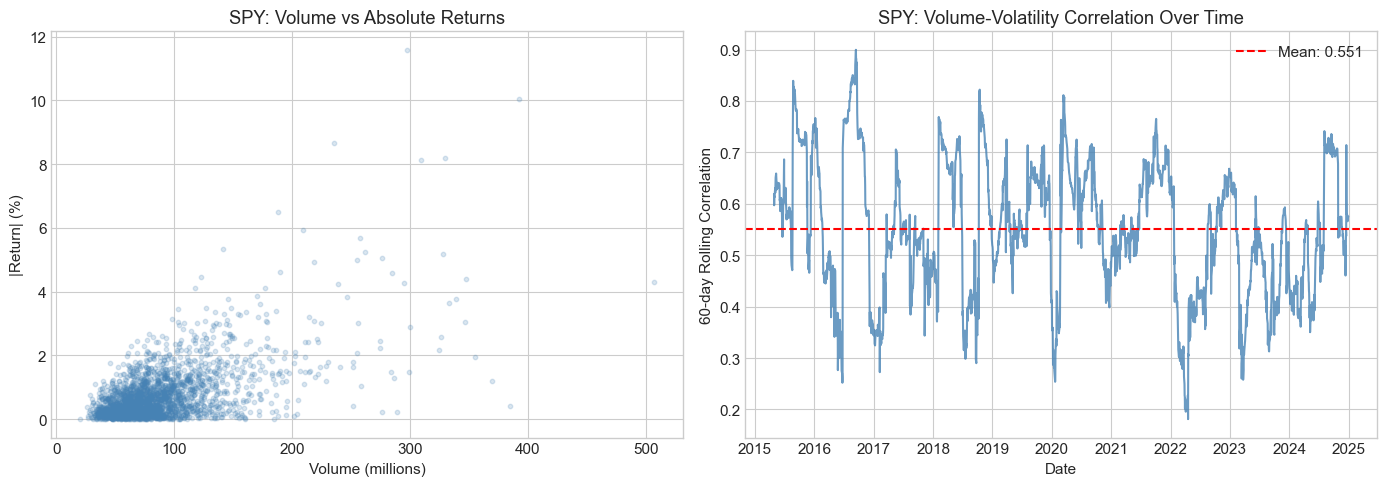


Overall correlation between volume and |returns|: 0.5870


In [18]:
# Analyze volume-volatility relationship for SPY
spy_data = yf.download('SPY', start=start_date, end=end_date, progress=False)
if isinstance(spy_data.columns, pd.MultiIndex):
    spy_data.columns = spy_data.columns.get_level_values(0)

spy_data['returns'] = np.log(spy_data['Close'] / spy_data['Close'].shift(1))
spy_data['abs_returns'] = np.abs(spy_data['returns'])
spy_data['volume_ma'] = spy_data['Volume'].rolling(20).mean()
spy_data['vol_20d'] = spy_data['returns'].rolling(20).std()
spy_data = spy_data.dropna()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(spy_data['Volume']/1e6, spy_data['abs_returns']*100, 
                alpha=0.2, s=10, c='steelblue')
axes[0].set_xlabel('Volume (millions)')
axes[0].set_ylabel('|Return| (%)')
axes[0].set_title('SPY: Volume vs Absolute Returns')

# Correlation over time
rolling_corr = spy_data['Volume'].rolling(60).corr(spy_data['abs_returns'])
axes[1].plot(rolling_corr.index, rolling_corr.values, color='steelblue', alpha=0.8)
axes[1].axhline(y=rolling_corr.mean(), color='red', linestyle='--', 
                label=f'Mean: {rolling_corr.mean():.3f}')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('60-day Rolling Correlation')
axes[1].set_title('SPY: Volume-Volatility Correlation Over Time')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nOverall correlation between volume and |returns|: {spy_data['Volume'].corr(spy_data['abs_returns']):.4f}")

## 5. Testing for ARCH Effects

Before fitting volatility models, we should formally test whether **ARCH effects** (conditional heteroskedasticity) are present.

### 5.1 Engle's ARCH-LM Test

Under the null hypothesis of no ARCH effects, regress squared residuals on their lags:

$$\epsilon_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \cdots + \alpha_q \epsilon_{t-q}^2 + v_t$$

Test statistic: $LM = T \cdot R^2 \sim \chi^2(q)$ under $H_0$

### 5.2 Ljung-Box Test on Squared Returns

Test for autocorrelation in squared returns:

$$Q(m) = T(T+2) \sum_{k=1}^{m} \frac{\hat{\rho}_k^2}{T-k} \sim \chi^2(m)$$

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

def test_arch_effects(returns_series, name, lags=10):
    """Test for ARCH effects using multiple tests."""
    ret = returns_series.dropna()
    
    # Demean returns
    resid = ret - ret.mean()
    
    # ARCH-LM test
    arch_test = het_arch(resid, nlags=lags)
    
    # Ljung-Box test on squared returns
    lb_test = acorr_ljungbox(resid**2, lags=[lags], return_df=True)
    
    print(f"\n{'='*60}")
    print(f"ARCH Effects Tests for {name}")
    print(f"{'='*60}")
    print(f"\nARCH-LM Test (q={lags}):")
    print(f"  LM Statistic: {arch_test[0]:.4f}")
    print(f"  p-value: {arch_test[1]:.6f}")
    print(f"  Conclusion: {'Reject H0 (ARCH effects present)' if arch_test[1] < 0.05 else 'Fail to reject H0'}")
    
    print(f"\nLjung-Box Test on Squared Returns (m={lags}):")
    print(f"  Q Statistic: {lb_test['lb_stat'].values[0]:.4f}")
    print(f"  p-value: {lb_test['lb_pvalue'].values[0]:.6f}")
    print(f"  Conclusion: {'Reject H0 (autocorrelation in squared returns)' if lb_test['lb_pvalue'].values[0] < 0.05 else 'Fail to reject H0'}")

for name, ret in returns.items():
    test_arch_effects(ret, name)


ARCH Effects Tests for S&P 500 ETF

ARCH-LM Test (q=10):
  LM Statistic: 960.3901
  p-value: 0.000000
  Conclusion: Reject H0 (ARCH effects present)

Ljung-Box Test on Squared Returns (m=10):
  Q Statistic: 3328.9704
  p-value: 0.000000
  Conclusion: Reject H0 (autocorrelation in squared returns)

ARCH Effects Tests for Bitcoin

ARCH-LM Test (q=10):
  LM Statistic: 120.5881
  p-value: 0.000000
  Conclusion: Reject H0 (ARCH effects present)

Ljung-Box Test on Squared Returns (m=10):
  Q Statistic: 159.4009
  p-value: 0.000000
  Conclusion: Reject H0 (autocorrelation in squared returns)

ARCH Effects Tests for EUR/USD

ARCH-LM Test (q=10):
  LM Statistic: 136.1443
  p-value: 0.000000
  Conclusion: Reject H0 (ARCH effects present)

Ljung-Box Test on Squared Returns (m=10):
  Q Statistic: 248.1804
  p-value: 0.000000
  Conclusion: Reject H0 (autocorrelation in squared returns)

ARCH Effects Tests for Gold Futures

ARCH-LM Test (q=10):
  LM Statistic: 135.8857
  p-value: 0.000000
  Conclus

## 6. Simple Volatility Estimators

Before moving to GARCH models, let's explore simple volatility estimators.

### 6.1 Rolling Window Volatility

The simplest approach: compute standard deviation over a rolling window.

$$\hat{\sigma}_t^{(n)} = \sqrt{\frac{1}{n-1} \sum_{i=0}^{n-1} (r_{t-i} - \bar{r})^2}$$

**Trade-off**: Short windows are noisy; long windows are slow to adapt.

### 6.2 Exponentially Weighted Moving Average (EWMA)

RiskMetrics approach: exponentially declining weights.

$$\sigma_t^2 = \lambda \sigma_{t-1}^2 + (1-\lambda) r_{t-1}^2$$

where typically $\lambda = 0.94$ (daily) or $\lambda = 0.97$ (monthly).

Equivalent to IGARCH(1,1) without a constant term.

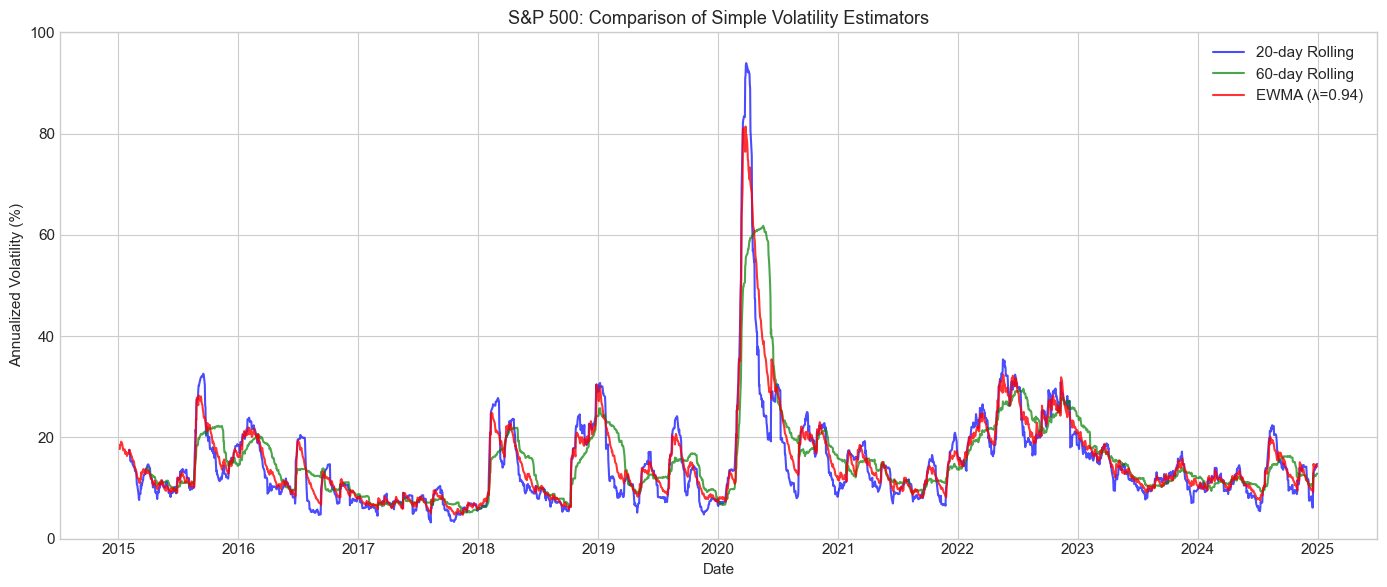

In [23]:
def compute_ewma_volatility(returns, lam=0.94):
    """Compute EWMA volatility (RiskMetrics approach)."""
    n = len(returns)
    var = np.zeros(n)
    
    # Initialize with sample variance
    var[0] = returns.var()
    
    for t in range(1, n):
        var[t] = lam * var[t-1] + (1 - lam) * returns.iloc[t-1]**2
    
    return pd.Series(np.sqrt(var), index=returns.index)

# Compare volatility estimators for S&P 500
spy_ret = returns['S&P 500 ETF']

fig, ax = plt.subplots(figsize=(14, 6))

# Rolling windows
for window, color in [(20, 'blue'), (60, 'green')]:
    rolling_vol = spy_ret.rolling(window).std() * np.sqrt(252) * 100
    ax.plot(rolling_vol.index, rolling_vol.values, label=f'{window}-day Rolling', 
            color=color, alpha=0.7)

# EWMA
ewma_vol = compute_ewma_volatility(spy_ret, lam=0.94) * np.sqrt(252) * 100
ax.plot(ewma_vol.index, ewma_vol.values, label='EWMA (λ=0.94)', 
        color='red', alpha=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Annualized Volatility (%)')
ax.set_title('S&P 500: Comparison of Simple Volatility Estimators', fontsize=13)
ax.legend(loc='upper right')
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

## 7. Summary and Preview

### Key Takeaways

1. **Financial returns violate GBM assumptions**: They exhibit heavy tails, volatility clustering, leverage effects, and long memory.

2. **Stylized Facts are universal**: These patterns appear across different assets, markets, and time periods.

3. **Volatility is predictable**: The autocorrelation in squared returns implies that volatility can be forecasted.

4. **Simple estimators have limitations**: Rolling windows and EWMA capture basic dynamics but lack theoretical foundations and statistical optimality.

### Course Roadmap

| Session | Topic |
|---------|-------|
| 1 | Foundations and Stylized Facts (today) |
| 2 | ARCH and GARCH Models |
| 3 | Asymmetric GARCH (EGARCH, GJR, TGARCH) |
| 4 | Advanced Univariate Models (FIGARCH, APARCH, Component GARCH) |
| 5 | Realized Volatility and High-Frequency Data |
| 6 | HAR Models and Realized Measures |
| 7 | Stochastic Volatility Models |
| 8 | Rough Volatility |
| 9 | Multivariate Volatility (DCC, BEKK) |
| 10 | Path-Dependent Volatility and Applications |

## Exercises

### Exercise 1: Cryptocurrency Stylized Facts
Download data for Ethereum (ETH-USD) and compare its stylized facts to Bitcoin. Do cryptocurrencies exhibit the same patterns as traditional assets?

### Exercise 2: Intraday vs Daily
Download intraday (hourly) Bitcoin data. How do the stylized facts change at higher frequencies?

### Exercise 3: Long Memory Estimation
Estimate the fractional differencing parameter $d$ for absolute returns using the GPH (Geweke-Porter-Hudak) estimator. What values do you find?

### Exercise 4: Rolling Skewness and Kurtosis
Compute 252-day rolling skewness and kurtosis for S&P 500 returns. How stable are these higher moments over time?

### Exercise 5: EWMA Sensitivity
Investigate how EWMA volatility estimates change for different values of λ (0.90, 0.94, 0.97, 0.99). Which value best captures the COVID-19 volatility spike?

## References

1. Cont, R. (2001). Empirical properties of asset returns: stylized facts and statistical issues. *Quantitative Finance*, 1(2), 223-236.

2. Bollerslev, T., Engle, R. F., & Nelson, D. B. (1994). ARCH models. *Handbook of Econometrics*, 4, 2959-3038.

3. Black, F. (1976). Studies of stock price volatility changes. *Proceedings of the 1976 Meetings of the American Statistical Association*, 177-181.

4. JP Morgan/Reuters. (1996). *RiskMetrics Technical Document*.

5. Taylor, S. J. (2008). *Modelling Financial Time Series*. World Scientific.